In [1]:
# Импорт библиотек
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# Загрузка модели и данных
multiclass_package = joblib.load('../models/best_multiclass_classifier.joblib')
model = multiclass_package['model']
label_encoder = multiclass_package['label_encoder']

X_normalized = pd.read_parquet('../data/processed/X_normalized.parquet')
feature_names = X_normalized.columns.tolist()

print(f"Модель: {type(model).__name__}")
print(f"Признаков: {len(feature_names)}")

Модель: XGBClassifier
Признаков: 49


In [2]:
def get_feature_importance(model, feature_names, top_n=20):
    # Проверяем тип модели и извлекаем важность
    if hasattr(model, 'feature_importances_'):
        importance_scores = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Для линейных моделей используем абсолютные значения коэффициентов
        importance_scores = np.abs(model.coef_).mean(axis=0)
    else:
        print("Модель не поддерживает анализ важности признаков")
        return None
    
    # Создаем DataFrame с важностью
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)
    
    print(f"Топ-{top_n} самых важных признаков:")
    print(importance_df.head(top_n).round(4))
    
    return importance_df

# Получаем важность признаков
importance_df = get_feature_importance(model, feature_names, top_n=20)

Топ-20 самых важных признаков:
                             feature  importance
37       remainder__cat__service_dns      0.4483
14              num__remainder__swin      0.1642
34         remainder__cat__proto_udp      0.0527
35        remainder__cat__proto_unas      0.0453
30         remainder__cat__proto_arp      0.0367
36         remainder__cat__service_-      0.0221
18            num__remainder__tcprtt      0.0210
7              num__remainder__dload      0.0206
32       remainder__cat__proto_other      0.0191
31        remainder__cat__proto_ospf      0.0163
6              num__remainder__sload      0.0146
21             num__remainder__smean      0.0130
4             num__remainder__dbytes      0.0111
39  remainder__cat__service_ftp-data      0.0109
22             num__remainder__dmean      0.0106
26  num__remainder__ct_dst_sport_ltm      0.0092
43         remainder__cat__state_CON      0.0089
40      remainder__cat__service_http      0.0077
25  num__remainder__ct_src_dport_ltm  

C:\Users\ro517\AppData\Local\Temp\ipykernel_3524\3821427989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


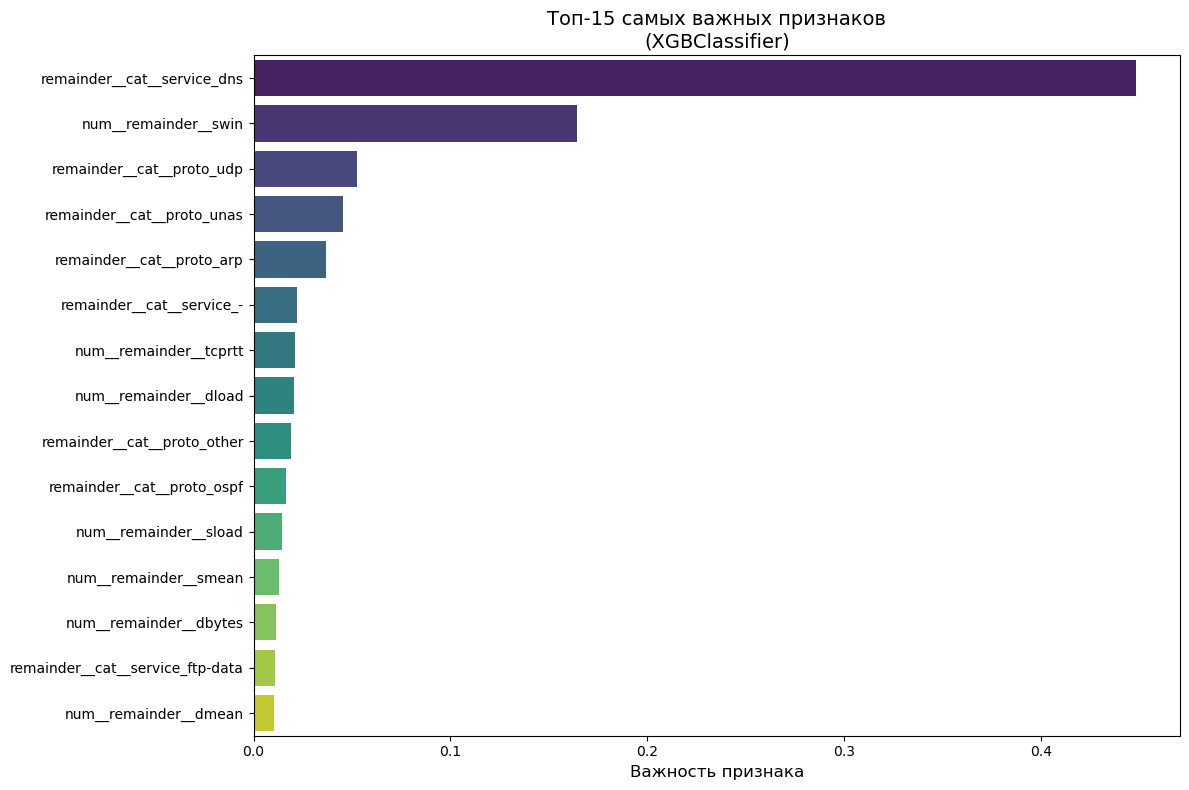

In [3]:
# Визуализация топ признаков
def plot_feature_importance(importance_df, top_n=15, model_name=""):  
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Топ-{top_n} самых важных признаков\n({model_name})', fontsize=14)
    plt.xlabel('Важность признака', fontsize=12)
    plt.ylabel('')
    plt.tight_layout()
    
    # Сохраняем график
    reports_path = Path("../reports/figures")
    reports_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(reports_path / 'feature_importance_top.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return top_features

# Визуализируем
top_features = plot_feature_importance(importance_df, top_n=15, model_name=type(model).__name__)


Важность по категориям признаков:
По типам:
  Numeric: 0.318 (31.8%)
  One-Hot: 0.682 (68.2%)

По группам (топ-10):
  Service: 0.495
  Other: 0.294
  Protocol: 0.170
  State: 0.017
  Bytes: 0.016
  Packets: 0.007
  Duration: 0.000


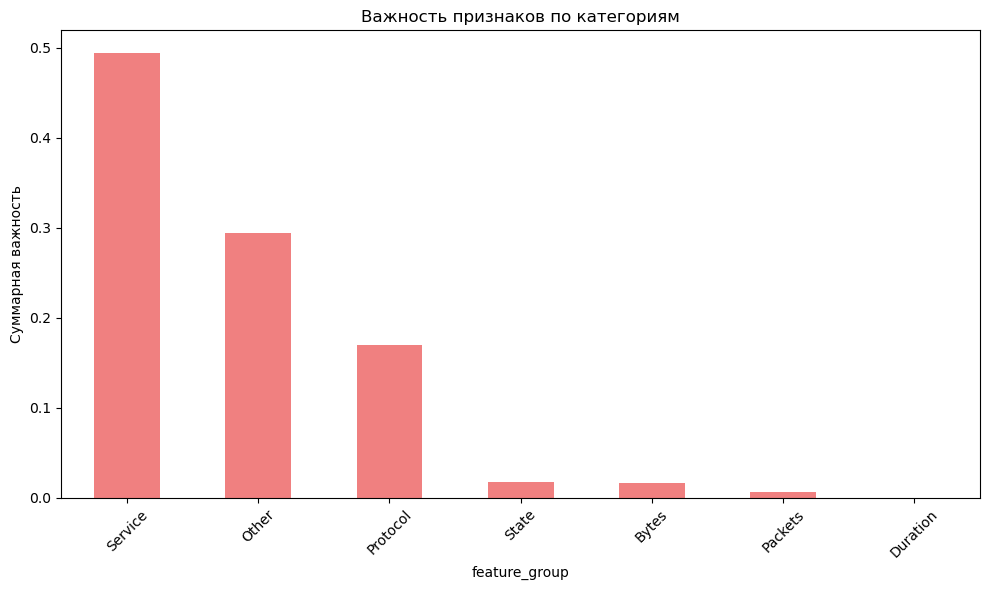

In [4]:
# Анализ важности по категориям признаков
def analyze_feature_categories(importance_df):
    # Группируем по типам признаков
    importance_df['feature_type'] = importance_df['feature'].apply(
        lambda x: 'One-Hot' if 'cat__' in x else 'Numeric'
    )
    
    importance_df['feature_group'] = importance_df['feature'].apply(
        lambda x: 'Protocol' if 'proto' in x else 
                 'Service' if 'service' in x else
                 'State' if 'state' in x else
                 'Bytes' if 'bytes' in x else
                 'Packets' if 'pkts' in x else
                 'Duration' if 'dur' in x else
                 'Flags' if 'flag' in x else
                 'Other'
    )
    
    # Суммарная важность по группам
    group_importance = importance_df.groupby('feature_group')['importance'].sum().sort_values(ascending=False)
    type_importance = importance_df.groupby('feature_type')['importance'].sum()
    
    print("\nВажность по категориям признаков:")
    print("По типам:")
    for feature_type, importance in type_importance.items():
        print(f"  {feature_type}: {importance:.3f} ({importance/sum(type_importance)*100:.1f}%)")
    
    print("\nПо группам (топ-10):")
    for group, importance in group_importance.head(10).items():
        print(f"  {group}: {importance:.3f}")
    
    # Визуализация по группам
    plt.figure(figsize=(10, 6))
    group_importance.head(10).plot(kind='bar', color='lightcoral')
    plt.title('Важность признаков по категориям')
    plt.ylabel('Суммарная важность')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return group_importance, type_importance

# Запускаем анализ категорий
group_importance, type_importance = analyze_feature_categories(importance_df)

In [5]:
# Анализ важности признаков для каждого типа атаки
def analyze_class_specific_importance(model, feature_names, label_encoder, top_n=10):
    
    if hasattr(model, 'feature_importances_'):
        # Для tree-based моделей обычно одна важность для всех классов
        print("Для этой модели важность признаков общая для всех классов")
        return None
    
    elif hasattr(model, 'coef_'):
        # Для линейных моделей - коэффициенты для каждого класса
        coef = model.coef_
        classes = label_encoder.classes_
        
        print(f"\nВажность по признакам атак:")
        
        for i, attack_type in enumerate(classes):
            class_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': np.abs(coef[i])
            }).sort_values('importance', ascending=False)
            
            print(f"\n{attack_type} (топ-{top_n}):")
            print(class_importance.head(top_n)['feature'].tolist())
        
        return coef
    else:
        return None

# Запускаем анализ по классам
class_importance = analyze_class_specific_importance(model, feature_names, label_encoder)

Для этой модели важность признаков общая для всех классов


In [6]:
# Генерация практических выводов
def generate_feature_insights(importance_df, top_n=10):
    top_features_list = importance_df.head(top_n)['feature'].tolist()
    
    insights = f"""
🔍 ИНСАЙТЫ ИЗ АНАЛИЗА ВАЖНОСТИ ПРИЗНАКОВ:

ТОП-{top_n} САМЫХ ВАЖНЫХ ПРИЗНАКОВ:
{chr(10).join([f'{i+1}. {feat}' for i, feat in enumerate(top_features_list)])}

ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ БЕЗОПАСНОСТИ:

1. КРИТИЧЕСКИЕ ХАРАКТЕРИСТИКИ СЕТЕВОГО ТРАФИКА:
   - Наиболее важные признаки показывают какие параметры трафика
     действительно отличают атаки от нормального трафика

2. ОПТИМИЗАЦИЯ СИСТЕМЫ МОНИТОРИНГА:
   - Можно сфокусироваться на мониторинге топ-{top_n} признаков
   - Упростить модель используя только важные признаки

3. ИНТЕРПРЕТАЦИЯ РЕШЕНИЙ МОДЕЛИ:
   - Когда модель обнаруживает атаку, можно объяснить ПОЧЕМУ
     на основе важных признаков

РЕКОМЕНДАЦИИ:
- Использовать эти инсайты для настройки правил межсетевого экрана
- Сфокусировать логирование на важных характеристиках трафика
- Рассмотреть упрощение модели используя только топ-{top_n * 2} признаков
"""
    
    print(insights)
    return insights

# Генерируем инсайты
feature_insights = generate_feature_insights(importance_df)


🔍 ИНСАЙТЫ ИЗ АНАЛИЗА ВАЖНОСТИ ПРИЗНАКОВ:

ТОП-10 САМЫХ ВАЖНЫХ ПРИЗНАКОВ:
1. remainder__cat__service_dns
2. num__remainder__swin
3. remainder__cat__proto_udp
4. remainder__cat__proto_unas
5. remainder__cat__proto_arp
6. remainder__cat__service_-
7. num__remainder__tcprtt
8. num__remainder__dload
9. remainder__cat__proto_other
10. remainder__cat__proto_ospf

ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ БЕЗОПАСНОСТИ:

1. КРИТИЧЕСКИЕ ХАРАКТЕРИСТИКИ СЕТЕВОГО ТРАФИКА:
   - Наиболее важные признаки показывают какие параметры трафика
     действительно отличают атаки от нормального трафика

2. ОПТИМИЗАЦИЯ СИСТЕМЫ МОНИТОРИНГА:
   - Можно сфокусироваться на мониторинге топ-10 признаков
   - Упростить модель используя только важные признаки

3. ИНТЕРПРЕТАЦИЯ РЕШЕНИЙ МОДЕЛИ:
   - Когда модель обнаруживает атаку, можно объяснить ПОЧЕМУ
     на основе важных признаков

РЕКОМЕНДАЦИИ:
- Использовать эти инсайты для настройки правил межсетевого экрана
- Сфокусировать логирование на важных характеристиках трафика
- Рассмот